In [ ]:
import pandas as pd
import numpy as np
import os
from huggingface_hub import hf_hub_download
from poi.settings import HF_ORG, HF_TOKEN

# Configuration
target_path = 'NYC'  # 'NYC' or 'TKY'
model_name = 'Nrqvae-NYC-div0.25-commit0.25-lr1e-3'  # Change based on target_path and desired model

# Download codebook CSV from Hugging Face
repo_id = f"{HF_ORG}/{target_path.lower()}"
codebook_filename = f"codebooks-{model_name}.csv"
codebook_hf_path = f"New LLM Dataset/Intermediate Files/{codebook_filename}"

print(f"📥 Downloading codebook from {repo_id}/{codebook_hf_path}")
codebook_path = hf_hub_download(
    repo_id=repo_id,
    repo_type="dataset",
    filename=codebook_hf_path,
    token=HF_TOKEN
)
codebook = pd.read_csv(codebook_path)
codebook.rename(columns={'Pid': 'poi_id'}, inplace=True)
codebook['Codebook'] = codebook['Codebook'].apply(eval)

# Download poi_info.csv and catname_mapping.csv from Hugging Face
print(f"📥 Downloading poi_info and mappings from {repo_id}")
poi_info_path = hf_hub_download(
    repo_id=repo_id,
    repo_type="dataset",
    filename="Intermediate Files/poi_info.csv",
    token=HF_TOKEN
)
catname_mapping_path = hf_hub_download(
    repo_id=repo_id,
    repo_type="dataset",
    filename="Intermediate Files/catname_mapping.csv",
    token=HF_TOKEN
)

# Load poi_info and mappings
poi_info = pd.read_csv(poi_info_path)
catname_mapping = pd.read_csv(catname_mapping_path)

# Create mapping dictionaries (reverse: Mapped_Catname -> Original_Catname)
cat_id_to_name = dict(zip(catname_mapping['Mapped_Catname'], catname_mapping['Original_Catname']))

# Prepare poi_info with renamed columns to match notebook expectations
poi_info_prep = poi_info[['Pid', 'Catname', 'Region']].copy()
poi_info_prep.rename(columns={
    'Pid': 'poi_id',
    'Catname': 'cat_id',  # This is already mapped ID
    'Region': 'region_id'  # This is already mapped ID
}, inplace=True)

# Add original catname using mapping
poi_info_prep['catname'] = poi_info_prep['cat_id'].map(cat_id_to_name)

# Merge codebook with poi_info
codebook = codebook.merge(poi_info_prep[['poi_id', 'cat_id', 'catname', 'region_id']], on='poi_id', how='left')

# 打印 codebook 的前5行，查看数据结构
print("\n📋 Codebook DataFrame 前5行数据:")
print("=" * 80)
print(codebook.head())
print("\n📋 列名:", codebook.columns.tolist())
print("📋 数据形状:", codebook.shape)
print("=" * 80 + "\n")

📥 Downloading codebook from comp5331poi/nyc_exploration/LLM Dataset/Intermediate Files/codebooks-Nrqvae-NYC_Exploration-div0.25-commit0.25-lr1e-3.csv
📥 Downloading poi_info and mappings from comp5331poi/nyc_exploration

📋 Codebook DataFrame 前5行数据:
   poi_id      Codebook                                             Vector  \
0       1   [17, 15, 5]  [-0.007114820182323456, 0.00017974781803786755...   
1       2    [4, 24, 3]  [-0.0019507426768541336, -0.002343414817005396...   
2       3  [20, 24, 28]  [-0.00307611096650362, -0.002814214676618576, ...   
3       4  [20, 25, 10]  [0.0006905142217874527, -0.01647697016596794, ...   
4       5  [20, 24, 28]  [-0.00307611096650362, -0.002814214676618576, ...   

   cat_id                catname  region_id  
0     140                  CafÃ©         56  
1     132               Tea Room         65  
2      17  Outdoors & Recreation         70  
3      81                 Subway         70  
4     132               Tea Room         70  

📋 列名: 

In [54]:
# ============================================================================
# 统计 codebook 第一层索引的出现频率（找出出现次数最多的索引）
# ============================================================================
print("\n📊 Codebook 第一层索引出现频率统计:")
print("=" * 60)
first_layer_indices = codebook['Codebook'].apply(lambda x: x[0] if len(x) > 0 else None)
# 按频率排序（出现次数从高到低）
frequency = first_layer_indices.value_counts().sort_values(ascending=False)

print(f"\n✅ 出现次数最多的前50个索引（按频率从高到低排序）:")
for idx, count in frequency.head(50).items():
    print(f"   索引 {idx}: {count:4d} 次")

print(f"\n💡 结论:")
print(f"   总共 {len(frequency)} 个不同的索引值")
print(f"   最常见的索引值: {frequency.index[0]} (出现 {frequency.iloc[0]} 次)")
print("=" * 60 + "\n")

# ============================================================================
# 统计排名前50的每个索引下，出现频率最高的前5个类别
# ============================================================================
print("\n📊 排名前50的每个索引下，出现频率最高的前5个类别:")
print("=" * 80)
top_50_indices = frequency.head(50).index.tolist()
groups_dict = {}

for rank, idx in enumerate(top_50_indices, 1):
    filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx)]
    top_categories = filtered_df['catname'].value_counts().head(5)
    groups_dict[idx] = top_categories.to_dict()
    
    print(f"\n排名 #{rank:2d}: 索引 {idx:2d} (共 {len(filtered_df):3d} 个 POI, 出现 {frequency[idx]:3d} 次)")
    for i, (cat, count) in enumerate(top_categories.items(), 1):
        print(f"    Top {i}: {cat:30s} - {count:3d} 次")

print("\n" + "=" * 80 + "\n")


📊 Codebook 第一层索引出现频率统计:

✅ 出现次数最多的前50个索引（按频率从高到低排序）:
   索引 20:  830 次
   索引 4:  816 次
   索引 26:  739 次
   索引 18:  309 次
   索引 17:  281 次
   索引 6:  161 次
   索引 9:  152 次
   索引 16:  149 次
   索引 0:  123 次
   索引 1:  111 次
   索引 13:  105 次
   索引 30:  102 次
   索引 12:   98 次
   索引 7:   88 次
   索引 27:   81 次
   索引 22:   78 次
   索引 25:   75 次
   索引 2:   74 次
   索引 15:   70 次
   索引 23:   69 次
   索引 14:   68 次
   索引 28:   68 次
   索引 29:   67 次
   索引 3:   67 次
   索引 10:   66 次
   索引 31:   61 次
   索引 5:   60 次
   索引 19:   58 次
   索引 11:   54 次
   索引 21:   29 次
   索引 24:   24 次
   索引 8:    2 次

💡 结论:
   总共 32 个不同的索引值
   最常见的索引值: 20 (出现 830 次)


📊 排名前50的每个索引下，出现频率最高的前5个类别:

排名 # 1: 索引 20 (共 830 个 POI, 出现 830 次)
    Top 1: Office                         - 110 次
    Top 2: Bar                            -  96 次
    Top 3: Coffee Shop                    -  68 次
    Top 4: Gym / Fitness Center           -  56 次
    Top 5: Burger Joint                   -  22 次

排名 # 2: 索引  4 (共 816 个 POI, 出现 816 次)
    

In [ ]:
# ============================================================================
# 随机挑选 4 个索引（threshold：最少出现50次）
# ============================================================================
import random

all_indices = [2, 12, 10, 22, 15, 20, 6, 9, 1, 29, 5, 3, 16, 14, 21, 4, 8, 7, 28, 25]

# random.seed(42)
selected_indices = random.sample(all_indices, k=4)

print("从所有索引中随机挑选的4个索引：")
for idx in selected_indices:
    print(f"索引 {idx}")

从所有索引中随机挑选的4个索引：
索引 21
索引 16
索引 22
索引 2


In [38]:
# 生成 group_1 到 group_4，使用 Cell 2 中随机挑选的索引
# 使用 selected_indices 变量统一管理索引值
idx1, idx2, idx3, idx4 = selected_indices

filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx1)]
group_1 = filtered_df['catname'].value_counts().head(5)
group_1 = group_1.to_dict()
print(group_1)

filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx2)]
group_2 = filtered_df['catname'].value_counts().head(5)
group_2 = group_2.to_dict()
print(group_2)

filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx3)]
group_3 = filtered_df['catname'].value_counts().head(5)
group_3 = group_3.to_dict()
print(group_3)

filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx4)]
group_4 = filtered_df['catname'].value_counts().head(5)
group_4 = group_4.to_dict()
print(group_4)

{'Office': 51, 'College Academic Building': 8, 'Deli / Bodega': 8, 'Church': 7, 'Gym / Fitness Center': 6}
{'Gym / Fitness Center': 23, 'Bus Station': 18, 'Home (private)': 14, 'Road': 6, 'Train Station': 6}
{'Office': 57, 'Coffee Shop': 45, 'College Academic Building': 11, 'Subway': 11, 'Food & Drink Shop': 7}
{'Office': 83, 'Coffee Shop': 23, 'Building': 11, 'Gym / Fitness Center': 10, 'Medical Center': 9}


['Office', 'Coffee Shop', 'Building', 'Gym / Fitness Center', 'Medical Center', 'College Academic Building', 'Deli / Bodega', 'Church', 'Bus Station', 'Home (private)', 'Road', 'Train Station', 'Subway', 'Food & Drink Shop']


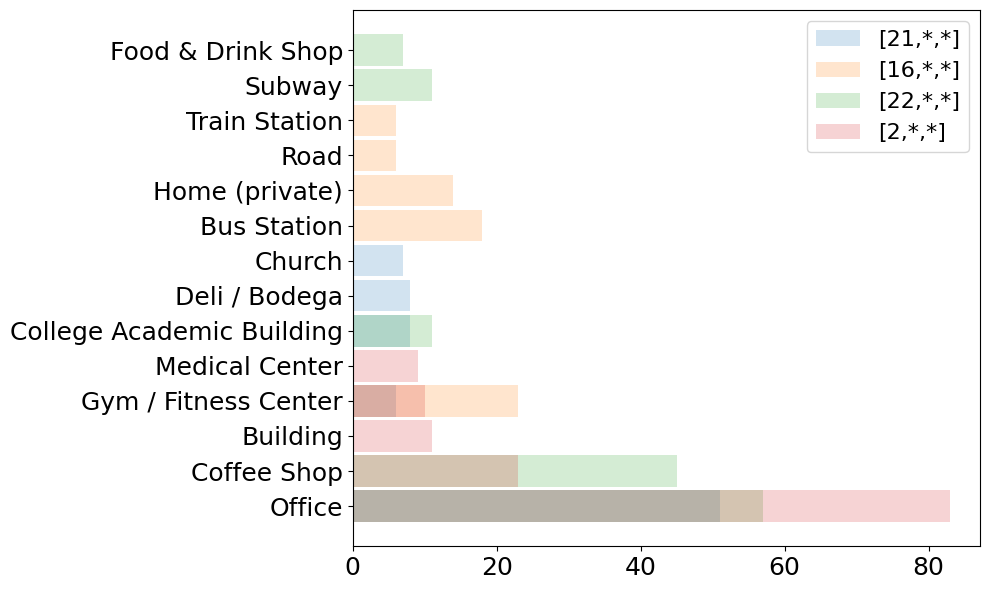

In [ ]:
import matplotlib.pyplot as plt

# Create output directory if it doesn't exist
output_dir = f'output/visualization/{target_path}'
os.makedirs(output_dir, exist_ok=True)

# 确保使用与 Cell 3 相同的索引变量
idx1, idx2, idx3, idx4 = selected_indices

# 合并所有的key
all_keys = []
for group in [group_4, group_1, group_2, group_3]:
    for key in group.keys():
        if key not in all_keys:
            all_keys.append(key)
print(all_keys)
# all_keys = sorted(set(group_1.keys()).union(set(group_2.keys())).union(set(group_3.keys()).union(set(group_4.keys()))))
# all_keys = sorted(set(group_1.keys()).union(set(group_2.keys())).union(set(group_3.keys())))

# 获取每个key在各组中的value（若某key不在某组中，视为0）

group_1_values = [group_1.get(key, 0) for key in all_keys]
group_2_values = [group_2.get(key, 0) for key in all_keys]
group_3_values = [group_3.get(key, 0) for key in all_keys]
group_4_values = [group_4.get(key, 0) for key in all_keys]

# 设置条形图位置
x = np.arange(len(all_keys))

# 设置条形图宽度
bar_width = 0.9
alpha = 0.2
# 绘制条形图
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制每一组的条形图（使用 Cell 3 中的索引变量）
rects1 = ax.barh(x, group_1_values, bar_width, label=f'[{idx1},*,*]', alpha=alpha)
rects2 = ax.barh(x, group_2_values, bar_width, label=f'[{idx2},*,*]', alpha=alpha)
rects3 = ax.barh(x, group_3_values, bar_width, label=f'[{idx3},*,*]', alpha=alpha)
rects4 = ax.barh(x, group_4_values, bar_width, label=f'[{idx4},*,*]', alpha=alpha)

# 添加标签和标题
# ax.set_ylabel('Catname', fontsize=24)
# ax.set_xlabel('Frequency Count', fontsize=24)

ax.set_yticks(x)
ax.set_yticklabels(all_keys, fontsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.legend(fontsize=16)

# 显示图形
# plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f'{output_dir}/semitic_bar.png', dpi=600)
plt.show()


以下是一次性生成十组random索引，并生成对应sid分类条形图以及tsne图的代码

In [55]:
import random

# 基础索引列表
all_indices = [20, 4, 26, 18, 17, 6, 9, 16, 0, 1, 13, 30, 12, 7, 27, 22, 25, 2, 15, 23]

# 生成10组随机4个索引（每组内无重复，组间可重复）
ten_index_groups = []
for _ in range(10):
    # 每次从all_indices中随机选4个不重复的索引
    selected = random.sample(all_indices, k=4)
    ten_index_groups.append(selected)

# 打印结果（与指定格式一致）
print("ten_index_groups = [")
for group in ten_index_groups:
    print(f"    {group},")
print("]")

ten_index_groups = [
    [1, 22, 13, 26],
    [15, 9, 27, 17],
    [25, 27, 30, 6],
    [13, 16, 26, 17],
    [16, 25, 7, 12],
    [15, 26, 17, 25],
    [9, 7, 20, 12],
    [18, 13, 20, 16],
    [23, 16, 2, 25],
    [30, 16, 27, 23],
]


In [56]:
import os
import numpy as np
import matplotlib.pyplot as plt

# 10组索引（保持原始顺序）
ten_index_groups = [
    [1, 22, 13, 26],
    [15, 9, 27, 17],
    [25, 27, 30, 6],
    [13, 16, 26, 17],
    [16, 25, 7, 12],
    [15, 26, 17, 25],
    [9, 7, 20, 12],
    [18, 13, 20, 16],
    [23, 16, 2, 25],
    [30, 16, 27, 23],
]

# 创建输出目录（确保路径正确，可根据实际情况修改）
output_dir = 'output/visualization'  # 移除了target_path变量，如需保留可自行补充
os.makedirs(output_dir, exist_ok=True)

# 循环处理10组索引
for group_num, selected_indices in enumerate(ten_index_groups, 1):
    # 提取当前组的4个索引
    idx1, idx2, idx3, idx4 = selected_indices
    
    # 1. 计算每组索引的top5类别
    groups = []
    for idx in selected_indices:
        # 筛选当前索引对应的POI
        filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx)]
        # 取top5类别并转为字典
        top5 = filtered_df['catname'].value_counts().head(5).to_dict()
        groups.append(top5)
    group_1, group_2, group_3, group_4 = groups  # 对应4个索引的top5
    
    # 2. 收集所有唯一类别（去重）
    all_keys = []
    for group in [group_1, group_2, group_3, group_4]:
        for key in group.keys():
            if key not in all_keys:
                all_keys.append(key)
    print(f"第{group_num}组 - 总类别数: {len(all_keys)}")
    
    # 3. 准备各组类别的数量（不存在的类别用0填充）
    group_1_values = [group_1.get(key, 0) for key in all_keys]
    group_2_values = [group_2.get(key, 0) for key in all_keys]
    group_3_values = [group_3.get(key, 0) for key in all_keys]
    group_4_values = [group_4.get(key, 0) for key in all_keys]
    
    # 4. 绘制条形图
    x = np.arange(len(all_keys))  # 类别数量作为y轴刻度
    bar_width = 0.9
    alpha = 0.2  # 透明度
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 绘制4个索引的条形图，标签显示对应的索引
    ax.barh(x, group_1_values, bar_width, label=f'[{idx1},*,*]', alpha=alpha)
    ax.barh(x, group_2_values, bar_width, label=f'[{idx2},*,*]', alpha=alpha)
    ax.barh(x, group_3_values, bar_width, label=f'[{idx3},*,*]', alpha=alpha)
    ax.barh(x, group_4_values, bar_width, label=f'[{idx4},*,*]', alpha=alpha)
    
    # 设置坐标轴和标签
    ax.set_yticks(x)
    ax.set_yticklabels(all_keys, fontsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.tick_params(axis='x', labelsize=18)
    ax.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc='upper left')  # 图例放右侧避免遮挡
    
    # 调整布局并保存
    plt.tight_layout()
    # 文件名包含组号和索引，例如：group_1_56-2-34-46.png
    index_str = "-".join(map(str, selected_indices))
    save_path = f"{output_dir}/group_{group_num}_{index_str}_bar.png"
    plt.savefig(save_path, dpi=600, bbox_inches='tight')  # 确保图例完整保存
    plt.close()  # 关闭当前图，释放内存
    
    print(f"第{group_num}组图已保存至: {save_path}")

print("10组条形图已全部生成！")

第1组 - 总类别数: 11
第1组图已保存至: output/visualization/group_1_1-22-13-26_bar.png
第2组 - 总类别数: 15
第2组图已保存至: output/visualization/group_2_15-9-27-17_bar.png
第3组 - 总类别数: 14
第3组图已保存至: output/visualization/group_3_25-27-30-6_bar.png
第4组 - 总类别数: 15
第4组图已保存至: output/visualization/group_4_13-16-26-17_bar.png
第5组 - 总类别数: 9
第5组图已保存至: output/visualization/group_5_16-25-7-12_bar.png
第6组 - 总类别数: 16
第6组图已保存至: output/visualization/group_6_15-26-17-25_bar.png
第7组 - 总类别数: 8
第7组图已保存至: output/visualization/group_7_9-7-20-12_bar.png
第8组 - 总类别数: 13
第8组图已保存至: output/visualization/group_8_18-13-20-16_bar.png
第9组 - 总类别数: 10
第9组图已保存至: output/visualization/group_9_23-16-2-25_bar.png
第10组 - 总类别数: 11
第10组图已保存至: output/visualization/group_10_30-16-27-23_bar.png
10组条形图已全部生成！


In [57]:
# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE

# # Use the same codebook data loaded in Cell 0
# # codebook is already loaded and merged with poi_info

# # 使用 Cell 2 中随机选择的索引
# selected_indices = [29, 37, 18, 13]

# # Prepare filtered data
# # 检查 Vector 列是否已经是列表类型，避免重复 eval
# if isinstance(codebook['Vector'].iloc[0], str):
#     codebook['Vector'] = codebook['Vector'].apply(eval)
# # 使用 selected_indices 中的4个索引
# filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx1 or x[0] == idx2 or x[0] == idx3 or x[0] == idx4)] 
# print(f"使用索引 {selected_indices}, 共 {len(filtered_df)} 个 POI")

# # 自动从四个索引的 top 5 类别中收集所有类别（去重）
# all_keys = []
# for idx in selected_indices:
#     idx_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx)]
#     top_cats = idx_df['catname'].value_counts().head(5).index.tolist()
#     for cat in top_cats:
#         if cat not in all_keys:
#             all_keys.append(cat)
# print(f"自动收集到 {len(all_keys)} 个类别: {all_keys}")

# filtered_df = filtered_df[['catname', 'Vector']]
# filtered_df = filtered_df[filtered_df['catname'].isin(all_keys)]
# print(len(filtered_df))

# # 将 `Vector` 列转化为numpy数组，便于t-SNE处理
# vectors = np.array(filtered_df['Vector'].to_list())

# # 使用t-SNE进行降维到2维
# tsne = TSNE(n_components=2, random_state=42)
# tsne_results = tsne.fit_transform(vectors)

# # 将降维后的结果添加到DataFrame中
# filtered_df['tsne_1'] = tsne_results[:, 0]
# filtered_df['tsne_2'] = tsne_results[:, 1]

# # 颜色按照类别排序逐渐变化
# # 将类别映射到指定顺序并生成颜色
# sorted_df = filtered_df[filtered_df['catname'].isin(all_keys)].copy()
# sorted_df['catname'] = pd.Categorical(sorted_df['catname'], categories=all_keys, ordered=True)
# sorted_df.sort_values('catname', inplace=True)

# # 使用渐变调色板
# num_categories = len(all_keys)
# palette = sns.color_palette("viridis", num_categories)  # 你可以改为 "plasma", "coolwarm" 等渐变调色板

# # 绘制 t-SNE 可视化
# fig, ax = plt.subplots(figsize=(10, 6))
# sns.scatterplot(
#     data=sorted_df,
#     x='tsne_1',
#     y='tsne_2',
#     hue='catname',
#     palette=palette,
#     s=100,
#     alpha=0.8,
#     ax=ax
# )
# # plt.title('t-SNE Visualization with Gradual Color Transition', fontsize=16)
# ax.set_xlabel('') # 显示设置为空字符串 t-SNE 1
# ax.set_ylabel('') # t-SNE 2
# ax.legend(title='Category', bbox_to_anchor=(-0.05, 1), loc='upper right', fontsize=10) #（1.05, 1）
# ax.tick_params(axis='y', labelsize=14)  
# ax.tick_params(axis='x', labelsize=14)
# plt.tight_layout()
# plt.savefig(f'{output_dir}/semitic_tsne.png', dpi=600)
# plt.show()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os

# ===================== 配置参数 =====================
# 10组索引（保持你提供的原始顺序）
ten_index_groups = [
    [1, 22, 13, 26],
    [15, 9, 27, 17],
    [25, 27, 30, 6],
    [13, 16, 26, 17],
    [16, 25, 7, 12],
    [15, 26, 17, 25],
    [9, 7, 20, 12],
    [18, 13, 20, 16],
    [23, 16, 2, 25],
    [30, 16, 27, 23],
]

# 输出文件夹（不存在则创建）
output_dir = "tsne_plots"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 检查Vector列格式（确保是列表类型）
if isinstance(codebook['Vector'].iloc[0], str):
    codebook['Vector'] = codebook['Vector'].apply(eval)

# ===================== 批量生成10张图 =====================
for group_idx, selected_indices in enumerate(ten_index_groups, 1):
    # 1. 筛选当前组索引对应的POI（第一个码元匹配任意一个索引）
    filtered_df = codebook[codebook['Codebook'].apply(
        lambda x: x[0] in selected_indices  # 简化判断逻辑，无需逐个写or
    )]
    print(f"第{group_idx}组 - 使用索引 {selected_indices}, 共 {len(filtered_df)} 个 POI")

    # 2. 自动收集当前组的top5类别（去重）
    all_keys = []
    for idx in selected_indices:
        idx_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx)]
        top_cats = idx_df['catname'].value_counts().head(5).index.tolist()
        all_keys.extend([cat for cat in top_cats if cat not in all_keys])
    print(f"第{group_idx}组 - 自动收集到 {len(all_keys)} 个类别")

    # 3. 过滤仅包含目标类别的数据
    filtered_df = filtered_df[['catname', 'Vector']]
    filtered_df = filtered_df[filtered_df['catname'].isin(all_keys)].reset_index(drop=True)
    if len(filtered_df) == 0:
        print(f"第{group_idx}组无有效数据，跳过")
        continue

    # 4. t-SNE降维（每组使用相同随机种子保证可复现）
    vectors = np.array(filtered_df['Vector'].to_list())
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(vectors)
    filtered_df['tsne_1'] = tsne_results[:, 0]
    filtered_df['tsne_2'] = tsne_results[:, 1]

    # 5. 类别排序与颜色配置
    filtered_df['catname'] = pd.Categorical(filtered_df['catname'], categories=all_keys, ordered=True)
    num_categories = len(all_keys)
    palette = sns.color_palette("viridis", num_categories)  # 渐变调色板

    # 6. 绘制并保存图
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.scatterplot(
        data=filtered_df,
        x='tsne_1',
        y='tsne_2',
        hue='catname',
        palette=palette,
        s=100,
        alpha=0.8,
        ax=ax
    )
    # 设置标题（标注组号和索引，便于识别）
    ax.set_title(f'Group {group_idx} - SID Prefixes {selected_indices}', fontsize=14, pad=15)
    ax.set_xlabel('')
    ax.set_ylabel('')
    # 图例位置优化（避免遮挡）
    ax.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax.tick_params(axis='both', labelsize=14)
    plt.tight_layout()  # 自动调整布局，防止图例被截断

    # 保存图片（文件名包含组号和索引，便于区分）
    index_str = "-".join(map(str, selected_indices))
    save_path = f"{output_dir}/tsne_group_{group_idx}_indices_{index_str}.png"
    plt.savefig(save_path, dpi=600, bbox_inches='tight')  # bbox_inches避免图例被裁掉
    plt.close()  # 关闭当前图，释放内存
    print(f"第{group_idx}组图已保存至: {save_path}\n")

print("10组t-SNE图已全部生成完成！")

第1组 - 使用索引 [1, 22, 13, 26], 共 1033 个 POI
第1组 - 自动收集到 11 个类别
第1组图已保存至: tsne_plots/tsne_group_1_indices_1-22-13-26.png

第2组 - 使用索引 [15, 9, 27, 17], 共 584 个 POI
第2组 - 自动收集到 15 个类别
第2组图已保存至: tsne_plots/tsne_group_2_indices_15-9-27-17.png

第3组 - 使用索引 [25, 27, 30, 6], 共 419 个 POI
第3组 - 自动收集到 14 个类别
第3组图已保存至: tsne_plots/tsne_group_3_indices_25-27-30-6.png

第4组 - 使用索引 [13, 16, 26, 17], 共 1274 个 POI
第4组 - 自动收集到 15 个类别
第4组图已保存至: tsne_plots/tsne_group_4_indices_13-16-26-17.png

第5组 - 使用索引 [16, 25, 7, 12], 共 410 个 POI
第5组 - 自动收集到 9 个类别
第5组图已保存至: tsne_plots/tsne_group_5_indices_16-25-7-12.png

第6组 - 使用索引 [15, 26, 17, 25], 共 1165 个 POI
第6组 - 自动收集到 16 个类别
第6组图已保存至: tsne_plots/tsne_group_6_indices_15-26-17-25.png

第7组 - 使用索引 [9, 7, 20, 12], 共 1168 个 POI
第7组 - 自动收集到 8 个类别
第7组图已保存至: tsne_plots/tsne_group_7_indices_9-7-20-12.png

第8组 - 使用索引 [18, 13, 20, 16], 共 1393 个 POI
第8组 - 自动收集到 13 个类别
第8组图已保存至: tsne_plots/tsne_group_8_indices_18-13-20-16.png

第9组 - 使用索引 [23, 16, 2, 25], 共 367 个 POI
第9组 - 自动收集到 10 个类